In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

class SpectrogramModifier:
    def __init__(self, sample_rate=16000, n_fft=256, hop_length=None, noise_strength=0.1):
        """
        SpectrogramModifier 클래스의 초기화 메서드.
        
        Args:
            sample_rate (int, optional): 샘플링 레이트 (Hz). 기본값은 16000.
            n_fft (int, optional): FFT 창 크기. 기본값은 256.
            hop_length (int, optional): STFT의 hop 길이. 기본값은 n_fft의 1/4.
            noise_strength (float, optional): 추가할 노이즈의 표준 편차. 기본값은 0.1.
        """
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length if hop_length is not None else n_fft // 4
        self.noise_strength = noise_strength
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None

    def generate_noise(self, signal):
        """
        입력 신호에 Gaussian 노이즈를 추가합니다.
        
        Args:
            signal (ndarray): 입력 신호.
        
        Returns:
            ndarray: 노이즈가 추가된 신호.
        """
        noise = np.random.normal(0, self.noise_strength, len(signal))
        return signal + noise

    def compute_spectrogram(self, signal):
        """
        입력 신호의 스펙트로그램을 계산하고 dB 스케일로 변환합니다.
        
        Args:
            signal (ndarray): 입력 신호.
        
        Returns:
            ndarray: dB 스케일의 스펙트로그램.
        """
        self.signal = signal
        self.signal_with_noise = self.generate_noise(signal)
        S = np.abs(librosa.stft(self.signal_with_noise, n_fft=self.n_fft, hop_length=self.hop_length, window='hann'))
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def add_horizontal_stripe_pattern_dB(self, stripe_freqs, intensity_factor=1.0):
        """
        지정된 주파수에 데시벨 스케일로 단일 가로선형 패턴을 추가합니다.
        
        Args:
            stripe_freqs (list): 'freq'와 'strength_dB'를 포함하는 딕셔너리 리스트.
            intensity_factor (float, optional): 패턴 강도 조절 계수. 기본값은 1.0.
        
        Returns:
            ndarray: 패턴이 추가된 스펙트로그램 dB 스케일 값.
        """
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다. 먼저 compute_spectrogram()을 호출하세요.")
        
        S_db_modified = self.S_db.copy()
        freqs = np.linspace(0, self.sample_rate / 2, S_db_modified.shape[0])
        
        for stripe in stripe_freqs:
            freq = stripe['freq']
            strength_dB = stripe['strength_dB'] * intensity_factor
            freq_idx = np.argmin(np.abs(freqs - freq))
            S_db_modified[freq_idx, :] += strength_dB
        
        self.S_db = S_db_modified
        return self.S_db

    def add_horizontal_energy_distribution_range_dB(self, stripe_freq_ranges, intensity_factor=1.0):
        """
        지정된 주파수 구간에 데시벨 스케일로 가로선형 패턴을 분포를 사용하여 추가합니다.
        각 구간에 대해 분포 유형과 매개변수를 지정할 수 있습니다.
        
        Args:
            stripe_freq_ranges (list): 
                각 딕셔너리는 'freq_min', 'freq_max', 'strength_dB', 
                'distribution', 'distribution_params'를 포함.
            intensity_factor (float, optional): 패턴 강도 조절 계수. 기본값은 1.0.
        
        Returns:
            ndarray: 패턴이 추가된 스펙트로그램 dB 스케일 값.
        """
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다. 먼저 compute_spectrogram()을 호출하세요.")
        
        S_db_modified = self.S_db.copy()
        freqs = np.linspace(0, self.sample_rate / 2, S_db_modified.shape[0])
    
        for stripe in stripe_freq_ranges:
            freq_min = stripe['freq_min']
            freq_max = stripe['freq_max']
            strength_dB = stripe['strength_dB'] * intensity_factor
            distribution = stripe.get('distribution', 'gaussian')
            distribution_params = stripe.get('distribution_params', {})
        
            # 주파수 구간 내의 주파수 인덱스 찾기
            freq_indices = np.where((freqs >= freq_min) & (freqs <= freq_max))[0]
    
            if len(freq_indices) == 0:
                print(f"주파수 구간 {freq_min}-{freq_max} Hz 내에 사용할 수 있는 주파수가 없습니다.")
                continue
    
            # 분포에 따라 주파수 에너지 분포 생성
            if distribution == 'gaussian':
                sigma = distribution_params.get('sigma', 5)
                center = (freq_min + freq_max) / 2
                gauss = np.exp(-0.5 * ((freqs[freq_indices] - center) / sigma) ** 2)
                gauss /= gauss.max()  # 정규화
                energy_distribution = gauss
            elif distribution == 'uniform':
                energy_distribution = np.ones_like(freqs[freq_indices])
                energy_distribution /= energy_distribution.max()  # 정규화
            elif distribution == 'exponential':
                scale = distribution_params.get('scale', 1.0)
                energy_distribution = np.exp(-freqs[freq_indices] / scale)
                energy_distribution /= energy_distribution.max()  # 정규화
            else:
                print(f"알 수 없는 분포 유형: {distribution}. 'gaussian' 분포를 사용합니다.")
                sigma = distribution_params.get('sigma', 5)
                center = (freq_min + freq_max) / 2
                gauss = np.exp(-0.5 * ((freqs[freq_indices] - center) / sigma) ** 2)
                gauss /= gauss.max()  # 정규화
                energy_distribution = gauss
    
            # 주파수 구간 내에 에너지 분포를 추가
            S_db_modified[freq_indices, :] += strength_dB * energy_distribution[:, np.newaxis]
    
        self.S_db = S_db_modified
        return self.S_db

    def add_random_horizontal_stripes_within_range_dB(self, freq_min, freq_max, strength_dB, 
                                                     n, mode='random'):
        """
        지정된 주파수 구간 내에서 n개의 단일 데시벨 스케일 가로선형 패턴을 선형 또는 무작위 방식으로 추가합니다.
        
        Args:
            freq_min (float): 주파수 구간의 최소값 (Hz).
            freq_max (float): 주파수 구간의 최대값 (Hz).
            strength_dB (float): 패턴의 강도 (dB).
            n (int): 생성할 가로선형 패턴의 개수.
            mode (str, optional): 'random' 또는 'linear'. 기본값은 'random'.
        
        Returns:
            ndarray: 패턴이 추가된 스펙트로그램 dB 스케일 값.
        """
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다. 먼저 compute_spectrogram()을 호출하세요.")
        
        S_db_modified = self.S_db.copy()
        freqs = np.linspace(0, self.sample_rate / 2, S_db_modified.shape[0])
        
        # 주파수 구간 내의 주파수 인덱스 찾기
        available_freqs = np.where((freqs >= freq_min) & (freqs <= freq_max))[0]
        
        if len(available_freqs) == 0:
            print(f"주파수 구간 {freq_min}-{freq_max} Hz 내에 사용할 수 있는 주파수가 없습니다.")
            return S_db_modified  # 주파수 구간에 주파수가 없으면 그대로 반환
        
        if mode == 'linear':
            # n개의 균등하게 분포된 주파수 선택
            selected_indices = np.linspace(available_freqs.min(), available_freqs.max(), num=n, dtype=int)
            selected_indices = selected_indices[selected_indices < len(freqs)]
        elif mode == 'random':
            # n개의 무작위 주파수 선택
            if n > len(available_freqs):
                print(f"요청한 패턴 수(n={n})가 주파수 구간 {freq_min}-{freq_max} Hz 내의 사용 가능한 주파수 수({len(available_freqs)})를 초과합니다. n을 {len(available_freqs)}로 조정합니다.")
                n = len(available_freqs)  # 가능한 최대 패턴 수로 조정
            selected_indices = np.random.choice(available_freqs, size=n, replace=False)
        else:
            print(f"알 수 없는 모드: {mode}. 'random' 모드를 사용합니다.")
            if n > len(available_freqs):
                n = len(available_freqs)
            selected_indices = np.random.choice(available_freqs, size=n, replace=False)
        
        for freq_idx in selected_indices:
            S_db_modified[freq_idx, :] += strength_dB  # 단일 주파수에 강도 추가
        
        self.S_db = S_db_modified
        return self.S_db

    def add_vertical_stripe_pattern_dB(self, stripe_times, intensity_factor=1.0):
        """
        지정된 시간에 데시벨 스케일로 단일 세로선형 패턴을 추가합니다.
        
        Args:
            stripe_times (list): 'time'과 'strength_dB'를 포함하는 딕셔너리 리스트.
            intensity_factor (float, optional): 패턴 강도 조절 계수. 기본값은 1.0.
        
        Returns:
            ndarray: 패턴이 추가된 스펙트로그램 dB 스케일 값.
        """
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다. 먼저 compute_spectrogram()을 호출하세요.")
        
        S_db_modified = self.S_db.copy()
        # 각 프레임의 시간 계산
        times = librosa.frames_to_time(np.arange(S_db_modified.shape[1]), sr=self.sample_rate, hop_length=self.hop_length)
        
        for stripe in stripe_times:
            time = stripe['time']
            strength_dB = stripe['strength_dB'] * intensity_factor
            # 지정된 시간에 가장 가까운 프레임 인덱스 찾기
            time_idx = np.argmin(np.abs(times - time))
            # 해당 프레임 전체 주파수에 패턴 추가
            S_db_modified[:, time_idx] += strength_dB
        
        self.S_db = S_db_modified
        return self.S_db

    def add_vertical_energy_distribution_range_dB(self, stripe_time_ranges, intensity_factor=1.0):
        """
        지정된 시간 구간에 데시벨 스케일로 세로선형 패턴을 분포를 사용하여 추가합니다.
        각 구간에 대해 분포 유형과 매개변수를 지정할 수 있습니다.
        
        Args:
            stripe_time_ranges (list): 
                각 딕셔너리는 'time_min', 'time_max', 'strength_dB', 
                'distribution', 'distribution_params'를 포함.
            intensity_factor (float, optional): 패턴 강도 조절 계수. 기본값은 1.0.
        
        Returns:
            ndarray: 패턴이 추가된 스펙트로그램 dB 스케일 값.
        """
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다. 먼저 compute_spectrogram()을 호출하세요.")
        
        S_db_modified = self.S_db.copy()
        # 각 프레임의 시간 계산
        times = librosa.frames_to_time(np.arange(S_db_modified.shape[1]), sr=self.sample_rate, hop_length=self.hop_length)
    
        for stripe in stripe_time_ranges:
            time_min = stripe['time_min']
            time_max = stripe['time_max']
            strength_dB = stripe['strength_dB'] * intensity_factor
            distribution = stripe.get('distribution', 'gaussian')
            distribution_params = stripe.get('distribution_params', {})
    
            # 시간 구간 내의 시간 인덱스 찾기
            time_indices = np.where((times >= time_min) & (times <= time_max))[0]
    
            if len(time_indices) == 0:
                print(f"시간 구간 {time_min}-{time_max} s 내에 사용할 수 있는 시간이 없습니다.")
                continue
    
            # 분포에 따라 시간 에너지 분포 생성
            if distribution == 'gaussian':
                sigma = distribution_params.get('sigma', 0.5)
                center = (time_min + time_max) / 2
                gauss = np.exp(-0.5 * ((times[time_indices] - center) / sigma) ** 2)
                gauss /= gauss.max()  # 정규화
                energy_distribution = gauss
            elif distribution == 'uniform':
                energy_distribution = np.ones_like(times[time_indices])
                energy_distribution /= energy_distribution.max()  # 정규화
            elif distribution == 'exponential':
                scale = distribution_params.get('scale', 1.0)
                energy_distribution = np.exp(-times[time_indices] / scale)
                energy_distribution /= energy_distribution.max()  # 정규화
            else:
                print(f"알 수 없는 분포 유형: {distribution}. 'gaussian' 분포를 사용합니다.")
                sigma = distribution_params.get('sigma', 0.5)
                center = (time_min + time_max) / 2
                gauss = np.exp(-0.5 * ((times[time_indices] - center) / sigma) ** 2)
                gauss /= gauss.max()  # 정규화
                energy_distribution = gauss
    
            # 시간 구간 내에 에너지 분포를 추가
            S_db_modified[:, time_indices] += strength_dB * energy_distribution[np.newaxis, :]
    
        self.S_db = S_db_modified
        return self.S_db

    def scale_spectrogram(self, scaling_factor=1.0):
        """
        전체 스펙트로그램의 dB 값을 스케일링합니다.
        
        Args:
            scaling_factor (float, optional): 스케일링 계수. 기본값은 1.0 (변경 없음).
        
        Returns:
            ndarray: 스케일링된 스펙트로그램 dB 스케일 값.
        """
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다. 먼저 compute_spectrogram()을 호출하세요.")
        
        self.S_db = self.S_db * scaling_factor
        return self.S_db

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram with Patterns'):
        """
        스펙트로그램을 시각화합니다.
        
        Args:
            show_labels (bool, optional): 축 레이블과 제목을 표시할지 여부. 기본값은 True.
            colormap (str, optional): 스펙트로그램에 사용할 Matplotlib 컬러맵. 기본값은 'magma'.
            title (str, optional): 스펙트로그램 제목. 기본값은 'Spectrogram with Patterns'.
        
        Returns:
            tuple: (fig, ax) Matplotlib figure와 axis 객체.
        """
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다. 먼저 compute_spectrogram()을 호출하세요.")
        
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
    
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')  # 축 제거
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # 여백 제거
    
        plt.tight_layout(pad=0.5)
        return fig, ax


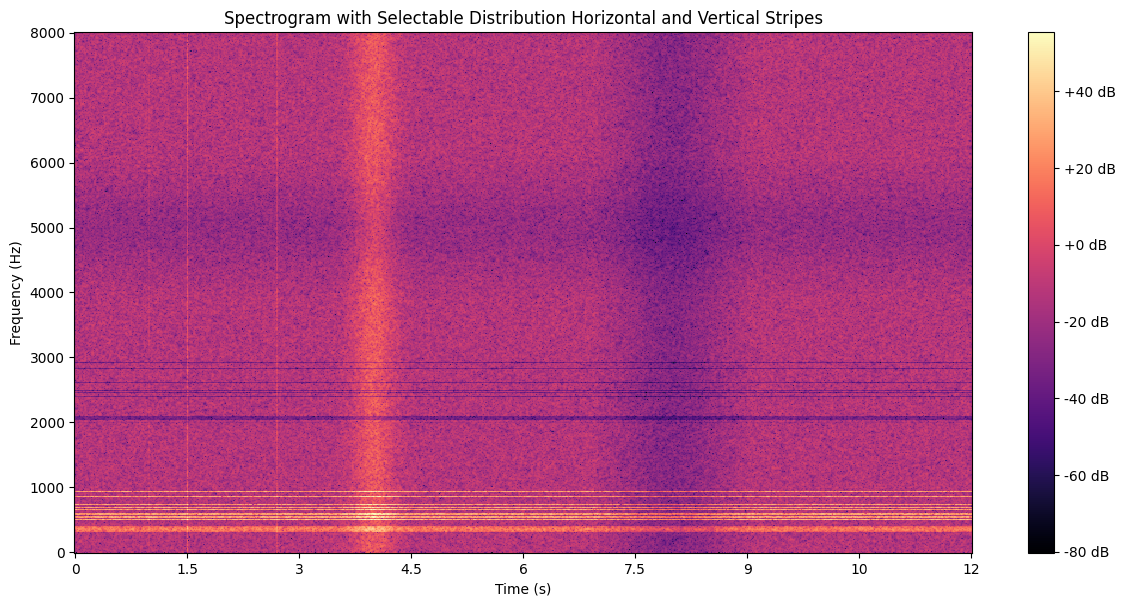

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# SpectrogramModifier 클래스 정의는 이전 코드 블록에 포함되어 있다고 가정합니다.

# 파라미터 설정
sample_rate = 16000  # 16 kHz
duration = 12  # 12초
n_samples = sample_rate * duration

# 신호 생성 (가우시안 노이즈)
np.random.seed(42)
signal = np.random.normal(0, 1, n_samples)  # 평균=0, 표준편차=1

# SpectrogramModifier 클래스 인스턴스 생성
spectro_mod = SpectrogramModifier(sample_rate=sample_rate, n_fft=1024, hop_length=None, noise_strength=5)

# 스펙트로그램 계산
S_db = spectro_mod.compute_spectrogram(signal)

# 가로선형 패턴 정의 (단일 주파수)
stripe_freqs = [
    {'freq': 500, 'strength_dB': 5},    # 500 Hz에서 +5 dB
    {'freq': 1000, 'strength_dB': 2},   # 1000 Hz에서 +2 dB
    {'freq': 2000, 'strength_dB': -5}   # 2000 Hz에서 -5 dB
]

# 가로선형 패턴 정의 (주파수 구간, Gaussian 윈도우 사용)
stripe_freq_ranges = [
    {
        'freq_min': 300, 
        'freq_max': 400, 
        'strength_dB': 30, 
        'distribution': 'gaussian',  # Gaussian 분포 사용
        'distribution_params': {'sigma': 50}  # sigma 값 설정
    },
    {
        'freq_min': 4000, 
        'freq_max': 6000, 
        'strength_dB': -10, 
        'distribution': 'gaussian',  # Gaussian 분포 사용
        'distribution_params': {'sigma': 500}  # sigma 값 설정
    }
]

# 임의의 가로선형 패턴 정의 (주파수 구간 내에서 n개, 무작위 방식 사용)
stripe_random_freq_ranges = [
    {'freq_min': 500, 'freq_max': 1000, 'strength_dB': 40, 'n': 10, 'mode': 'random'},  # 500-1000 Hz 내에서 10개 패턴 (+40 dB)
    {'freq_min': 2000, 'freq_max': 3000, 'strength_dB': -20, 'n': 10, 'mode': 'random'}  # 2000-3000 Hz 내에서 10개 패턴 (-20 dB)
]

# 세로선형 패턴 정의 (단일 시간)
stripe_times = [
    {'time': 1, 'strength_dB': 5},    # 1초 지점에서 +5 dB
    {'time': 2.7, 'strength_dB': 10}, # 2.7초 지점에서 +10 dB
    {'time': 1.5, 'strength_dB': 15}  # 1.5초 지점에서 +15 dB
]

# 세로선형 패턴 정의 (시간 구간, Gaussian 윈도우 사용)
stripe_time_ranges = [
    {
        'time_min': 3, 
        'time_max': 5, 
        'strength_dB': 20, 
        'distribution': 'gaussian',  # Gaussian 분포 사용
        'distribution_params': {'sigma': 0.2}  # sigma 값 설정
    },
    {
        'time_min': 7, 
        'time_max': 9, 
        'strength_dB': -15, 
        'distribution': 'gaussian',  # Gaussian 분포 사용
        'distribution_params': {'sigma': 0.5}  # sigma 값 설정
    }
]

# 패턴 추가: 단일 주파수에 가로선형 패턴 추가
spectro_mod.add_horizontal_stripe_pattern_dB(stripe_freqs, intensity_factor=1.0)

# 패턴 추가: 주파수 구간에 Gaussian 윈도우를 사용하여 가로선형 패턴 추가
spectro_mod.add_horizontal_energy_distribution_range_dB(stripe_freq_ranges, intensity_factor=1.0)

# 패턴 추가: 주파수 구간 내에서 랜덤 방식으로 단일 주파수에 가로선형 패턴 추가
for stripe in stripe_random_freq_ranges:
    spectro_mod.add_random_horizontal_stripes_within_range_dB(
        freq_min=stripe['freq_min'],
        freq_max=stripe['freq_max'],
        strength_dB=stripe['strength_dB'],
        n=stripe['n'],
        mode=stripe['mode']
    )

# 패턴 추가: 단일 시간에 세로선형 패턴 추가
spectro_mod.add_vertical_stripe_pattern_dB(stripe_times, intensity_factor=1.0)

# 패턴 추가: 시간 구간에 Gaussian 윈도우를 사용하여 세로선형 패턴 추가
spectro_mod.add_vertical_energy_distribution_range_dB(stripe_time_ranges, intensity_factor=1.0)

# 전체 스펙트로그램의 dB 값 스케일링 (옵션)
spectro_mod.scale_spectrogram(scaling_factor=1.0)  # 1.0이면 변경 없음

# 스펙트로그램 시각화
fig, ax = spectro_mod.plot_spectrogram(
    show_labels=True,
    colormap='magma',
    title='Spectrogram with Selectable Distribution Horizontal and Vertical Stripes'
)
plt.show()

# 스펙트로그램 저장 (옵션)
# fig.savefig('spectrogram_with_patterns.png', dpi=300, bbox_inches='tight')


주파수 500 Hz 지점에 50.0 dB 가로선형 패턴 추가
0 Hz~5000 Hz, 0.5 s~1.0 s 구간에 white 노이즈 50 dB 추가


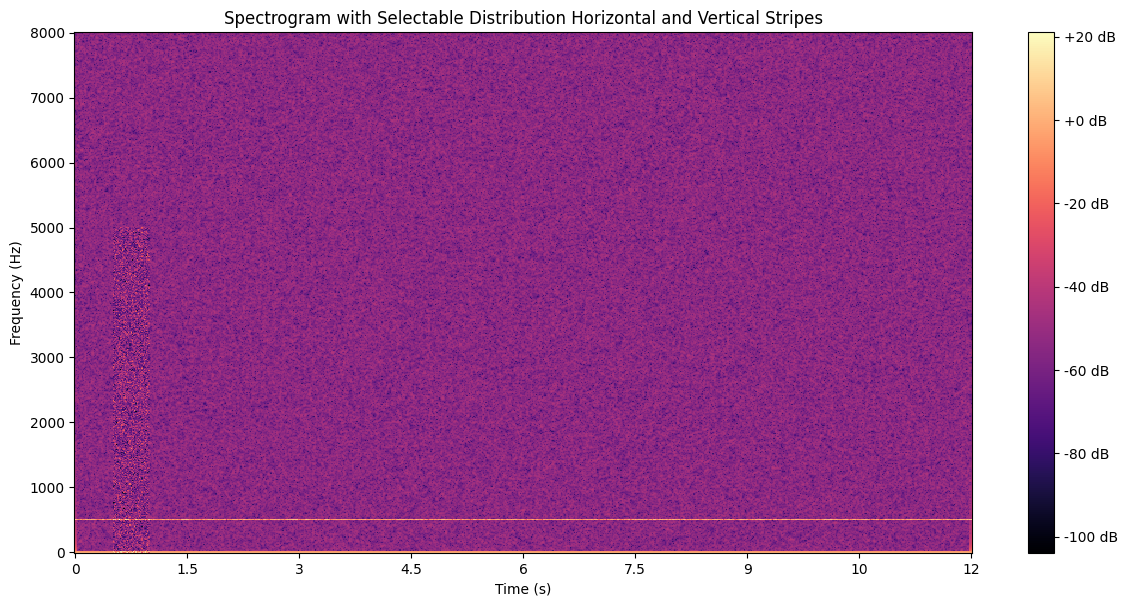

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

class SpectrogramModifier:
    def __init__(
        self,
        sample_rate=16000,
        n_fft=256,
        hop_length=None,
        noise_strength=0.1
    ):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length if hop_length is not None else n_fft // 4
        self.noise_strength = noise_strength
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None
        self.transform_log = []  # 변형 기록용 로그 리스트

    def generate_noise(self, signal):
        noise = np.random.normal(0, self.noise_strength, len(signal))
        return signal + noise

    def compute_spectrogram(self, signal):
        self.signal = signal
        self.signal_with_noise = self.generate_noise(signal)
        S = np.abs(
            librosa.stft(
                self.signal_with_noise,
                n_fft=self.n_fft,
                hop_length=self.hop_length,
                window='hann'
            )
        )
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def add_horizontal_stripe_pattern_dB(self, stripe_freqs, intensity_factor=1.0):
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다.")
        S_db_modified = self.S_db.copy()
        freqs = np.linspace(0, self.sample_rate / 2, S_db_modified.shape[0])
        for stripe in stripe_freqs:
            freq = stripe['freq']
            strength_dB = stripe['strength_dB'] * intensity_factor
            freq_idx = np.argmin(np.abs(freqs - freq))
            S_db_modified[freq_idx, :] += strength_dB
            self.transform_log.append({
                'type': 'horizontal_line',
                'freq': freq,
                'strength_dB': strength_dB
            })
        self.S_db = S_db_modified
        return self.S_db

    def add_horizontal_energy_distribution_range_dB(self, stripe_freq_ranges, intensity_factor=1.0):
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다.")
        S_db_modified = self.S_db.copy()
        freqs = np.linspace(0, self.sample_rate / 2, S_db_modified.shape[0])
        for stripe in stripe_freq_ranges:
            freq_min = stripe['freq_min']
            freq_max = stripe['freq_max']
            strength_dB = stripe['strength_dB'] * intensity_factor
            distribution = stripe.get('distribution', 'gaussian')
            distribution_params = stripe.get('distribution_params', {})
            freq_indices = np.where((freqs >= freq_min) & (freqs <= freq_max))[0]

            if len(freq_indices) == 0:
                continue

            if distribution == 'gaussian':
                sigma = distribution_params.get('sigma', 5)
                center = (freq_min + freq_max) / 2
                gauss = np.exp(-0.5 * ((freqs[freq_indices] - center) / sigma) ** 2)
                gauss /= gauss.max()
                energy_distribution = gauss
            elif distribution == 'uniform':
                energy_distribution = np.ones_like(freqs[freq_indices])
                energy_distribution /= energy_distribution.max()
            elif distribution == 'exponential':
                scale = distribution_params.get('scale', 1.0)
                energy_distribution = np.exp(-freqs[freq_indices] / scale)
                energy_distribution /= energy_distribution.max()
            else:
                sigma = distribution_params.get('sigma', 5)
                center = (freq_min + freq_max) / 2
                gauss = np.exp(-0.5 * ((freqs[freq_indices] - center) / sigma) ** 2)
                gauss /= gauss.max()
                energy_distribution = gauss

            S_db_modified[freq_indices, :] += strength_dB * energy_distribution[:, np.newaxis]
            self.transform_log.append({
                'type': 'horizontal_range',
                'freq_min': freq_min,
                'freq_max': freq_max,
                'strength_dB': strength_dB,
                'distribution': distribution
            })
        self.S_db = S_db_modified
        return self.S_db

    def add_random_horizontal_stripes_within_range_dB(self, freq_min, freq_max, strength_dB, n, mode='random'):
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다.")
        S_db_modified = self.S_db.copy()
        freqs = np.linspace(0, self.sample_rate / 2, S_db_modified.shape[0])
        available_freqs = np.where((freqs >= freq_min) & (freqs <= freq_max))[0]

        if len(available_freqs) == 0:
            return S_db_modified

        if mode == 'linear':
            selected_indices = np.linspace(
                available_freqs.min(),
                available_freqs.max(),
                num=n,
                dtype=int
            )
            selected_indices = selected_indices[selected_indices < len(freqs)]
        elif mode == 'random':
            if n > len(available_freqs):
                n = len(available_freqs)
            selected_indices = np.random.choice(available_freqs, size=n, replace=False)
        else:
            if n > len(available_freqs):
                n = len(available_freqs)
            selected_indices = np.random.choice(available_freqs, size=n, replace=False)

        for freq_idx in selected_indices:
            S_db_modified[freq_idx, :] += strength_dB
            self.transform_log.append({
                'type': 'horizontal_random_line',
                'freq_index': freq_idx,
                'strength_dB': strength_dB
            })

        self.S_db = S_db_modified
        return self.S_db

    def add_vertical_stripe_pattern_dB(self, stripe_times, intensity_factor=1.0):
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다.")
        S_db_modified = self.S_db.copy()
        times = librosa.frames_to_time(
            np.arange(S_db_modified.shape[1]),
            sr=self.sample_rate,
            hop_length=self.hop_length
        )
        for stripe in stripe_times:
            time = stripe['time']
            strength_dB = stripe['strength_dB'] * intensity_factor
            time_idx = np.argmin(np.abs(times - time))
            S_db_modified[:, time_idx] += strength_dB
            self.transform_log.append({
                'type': 'vertical_line',
                'time': time,
                'strength_dB': strength_dB
            })
        self.S_db = S_db_modified
        return self.S_db

    def add_vertical_energy_distribution_range_dB(self, stripe_time_ranges, intensity_factor=1.0):
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다.")
        S_db_modified = self.S_db.copy()
        times = librosa.frames_to_time(
            np.arange(S_db_modified.shape[1]),
            sr=self.sample_rate,
            hop_length=self.hop_length
        )
        for stripe in stripe_time_ranges:
            time_min = stripe['time_min']
            time_max = stripe['time_max']
            strength_dB = stripe['strength_dB'] * intensity_factor
            distribution = stripe.get('distribution', 'gaussian')
            distribution_params = stripe.get('distribution_params', {})
            time_indices = np.where((times >= time_min) & (times <= time_max))[0]

            if len(time_indices) == 0:
                continue

            if distribution == 'gaussian':
                sigma = distribution_params.get('sigma', 0.5)
                center = (time_min + time_max) / 2
                gauss = np.exp(-0.5 * ((times[time_indices] - center) / sigma) ** 2)
                gauss /= gauss.max()
                energy_distribution = gauss
            elif distribution == 'uniform':
                energy_distribution = np.ones_like(times[time_indices])
                energy_distribution /= energy_distribution.max()
            elif distribution == 'exponential':
                scale = distribution_params.get('scale', 1.0)
                energy_distribution = np.exp(-times[time_indices] / scale)
                energy_distribution /= energy_distribution.max()
            else:
                sigma = distribution_params.get('sigma', 0.5)
                center = (time_min + time_max) / 2
                gauss = np.exp(-0.5 * ((times[time_indices] - center) / sigma) ** 2)
                gauss /= gauss.max()
                energy_distribution = gauss

            S_db_modified[:, time_indices] += strength_dB * energy_distribution[np.newaxis, :]
            self.transform_log.append({
                'type': 'vertical_range',
                'time_min': time_min,
                'time_max': time_max,
                'strength_dB': strength_dB,
                'distribution': distribution
            })

        self.S_db = S_db_modified
        return self.S_db

    def scale_spectrogram(self, scaling_factor=1.0):
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다.")
        self.S_db = self.S_db * scaling_factor
        self.transform_log.append({
            'type': 'scale',
            'factor': scaling_factor
        })
        return self.S_db

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram with Patterns'):
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다.")
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0.5)
        return fig, ax

    def add_noise_pattern(
        self,
        freq_min,
        freq_max,
        time_min,
        time_max,
        noise_strength_dB=5,
        noise_type='white',
        distribution_params=None
    ):
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다.")
        if distribution_params is None:
            distribution_params = {}
        S_db_modified = self.S_db.copy()

        freqs = np.linspace(0, self.sample_rate / 2, S_db_modified.shape[0])
        times = librosa.frames_to_time(
            np.arange(S_db_modified.shape[1]),
            sr=self.sample_rate,
            hop_length=self.hop_length
        )

        freq_indices = np.where((freqs >= freq_min) & (freqs <= freq_max))[0]
        time_indices = np.where((times >= time_min) & (times <= time_max))[0]

        if len(freq_indices) == 0 or len(time_indices) == 0:
            return self.S_db

        # 화이트 노이즈 생성
        if noise_type == 'white':
            noise_region = np.random.normal(
                0,
                1,
                (len(freq_indices), len(time_indices))
            )
            noise_region_db = noise_region / np.max(np.abs(noise_region)) * noise_strength_dB
        else:
            noise_region_db = np.zeros((len(freq_indices), len(time_indices)))

        S_db_modified[freq_indices[:, np.newaxis], time_indices] += noise_region_db
        self.S_db = S_db_modified
        self.transform_log.append({
            'type': 'noise_pattern',
            'freq_min': freq_min,
            'freq_max': freq_max,
            'time_min': time_min,
            'time_max': time_max,
            'noise_strength_dB': noise_strength_dB,
            'noise_type': noise_type
        })
        return self.S_db

    def add_realworld_noise(
        self,
        noise_path,
        freq_min,
        freq_max,
        time_min,
        time_max,
        noise_strength_dB=5
    ):
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다.")

        # 실제 잡음 로드
        try:
            noise_sig, sr = librosa.load(noise_path, sr=self.sample_rate)
        except:
            return self.S_db

        # 잡음 STFT 계산
        N = len(noise_sig)
        if N < self.n_fft:
            return self.S_db
        noise_S = np.abs(librosa.stft(noise_sig, n_fft=self.n_fft, hop_length=self.hop_length, window='hann'))
        noise_S_db = librosa.amplitude_to_db(noise_S, ref=np.max)

        # 주파수/시간 인덱스 계산
        freqs = np.linspace(0, self.sample_rate / 2, self.S_db.shape[0])
        times = librosa.frames_to_time(
            np.arange(self.S_db.shape[1]),
            sr=self.sample_rate,
            hop_length=self.hop_length
        )
        freq_indices = np.where((freqs >= freq_min) & (freqs <= freq_max))[0]
        time_indices = np.where((times >= time_min) & (times <= time_max))[0]

        if len(freq_indices) == 0 or len(time_indices) == 0:
            return self.S_db

        S_db_modified = self.S_db.copy()

        # 잡음 스펙트로그램 크기와 대상 영역 크기 조정
        # 영역에 맞게 잡음을 리샘플링 (단순 축소/확장)
        noise_sub = noise_S_db[:len(freq_indices), :len(time_indices)]
        if noise_sub.size == 0:
            return self.S_db

        # 노이즈 강도 조절
        max_val = np.max(np.abs(noise_sub))
        if max_val != 0:
            noise_sub = noise_sub / max_val * noise_strength_dB

        S_db_modified[freq_indices[:, np.newaxis], time_indices] += noise_sub
        self.S_db = S_db_modified
        self.transform_log.append({
            'type': 'realworld_noise',
            'noise_path': noise_path,
            'freq_min': freq_min,
            'freq_max': freq_max,
            'time_min': time_min,
            'time_max': time_max,
            'noise_strength_dB': noise_strength_dB
        })
        return self.S_db

    def add_shape_noise(
        self,
        shape='rectangle',
        freq_min=None,
        freq_max=None,
        time_min=None,
        time_max=None,
        center_freq=None,
        center_time=None,
        radius=None,
        noise_strength_dB=5
    ):
        if self.S_db is None:
            raise ValueError("스펙트로그램이 계산되지 않았습니다.")

        S_db_modified = self.S_db.copy()
        freqs = np.linspace(0, self.sample_rate / 2, S_db_modified.shape[0])
        times = librosa.frames_to_time(
            np.arange(S_db_modified.shape[1]),
            sr=self.sample_rate,
            hop_length=self.hop_length
        )

        if shape == 'rectangle':
            if freq_min is None or freq_max is None or time_min is None or time_max is None:
                return self.S_db
            freq_indices = np.where((freqs >= freq_min) & (freqs <= freq_max))[0]
            time_indices = np.where((times >= time_min) & (times <= time_max))[0]
            if len(freq_indices) == 0 or len(time_indices) == 0:
                return self.S_db
            rect_noise = np.random.normal(0, 1, (len(freq_indices), len(time_indices)))
            rect_noise_db = rect_noise / np.max(np.abs(rect_noise)) * noise_strength_dB
            S_db_modified[freq_indices[:, np.newaxis], time_indices] += rect_noise_db
            self.transform_log.append({
                'type': 'shape_noise',
                'shape': 'rectangle',
                'freq_min': freq_min,
                'freq_max': freq_max,
                'time_min': time_min,
                'time_max': time_max,
                'noise_strength_dB': noise_strength_dB
            })

        elif shape == 'circle':
            if center_freq is None or center_time is None or radius is None:
                return self.S_db
            freq_map = np.arange(S_db_modified.shape[0])
            time_map = np.arange(S_db_modified.shape[1])

            # 중심 freq/time 인덱스 찾기
            c_freq_idx = np.argmin(np.abs(freqs - center_freq))
            c_time_idx = np.argmin(np.abs(times - center_time))

            freq_grid, time_grid = np.meshgrid(freq_map, time_map, indexing='ij')
            dist = np.sqrt((freq_grid - c_freq_idx)**2 + (time_grid - c_time_idx)**2)

            mask = dist <= radius
            circle_noise = np.random.normal(0, 1, mask.sum())
            circle_noise_db = circle_noise / np.max(np.abs(circle_noise)) * noise_strength_dB
            S_db_modified[mask] += circle_noise_db.reshape(-1)

            self.transform_log.append({
                'type': 'shape_noise',
                'shape': 'circle',
                'center_freq': center_freq,
                'center_time': center_time,
                'radius': radius,
                'noise_strength_dB': noise_strength_dB
            })

        self.S_db = S_db_modified
        return self.S_db

    def generate_explain_text(self):
        texts = []
        for t in self.transform_log:
            if t['type'] == 'horizontal_line':
                texts.append(f"주파수 {t['freq']} Hz 지점에 {t['strength_dB']} dB 가로선형 패턴 추가")
            elif t['type'] == 'horizontal_range':
                texts.append(
                    f"주파수 {t['freq_min']} Hz부터 {t['freq_max']} Hz 구간에 {t['distribution']} 분포로 {t['strength_dB']} dB 가로선형 패턴 추가"
                )
            elif t['type'] == 'horizontal_random_line':
                texts.append(
                    f"특정 주파수 인덱스 {t['freq_index']}에 {t['strength_dB']} dB 랜덤 가로선형 패턴 추가"
                )
            elif t['type'] == 'vertical_line':
                texts.append(f"시간 {t['time']} s 지점에 {t['strength_dB']} dB 세로선형 패턴 추가")
            elif t['type'] == 'vertical_range':
                texts.append(
                    f"시간 {t['time_min']} s부터 {t['time_max']} s 구간에 {t['distribution']} 분포로 {t['strength_dB']} dB 세로선형 패턴 추가"
                )
            elif t['type'] == 'scale':
                texts.append(f"스펙트로그램 전체를 {t['factor']} 배 스케일링")
            elif t['type'] == 'noise_pattern':
                texts.append(
                    f"{t['freq_min']} Hz~{t['freq_max']} Hz, {t['time_min']} s~{t['time_max']} s 구간에 {t['noise_type']} 노이즈 {t['noise_strength_dB']} dB 추가"
                )
            elif t['type'] == 'realworld_noise':
                texts.append(
                    f"{t['noise_path']}에서 로드한 실제 잡음을 {t['freq_min']} Hz~{t['freq_max']} Hz, {t['time_min']} s~{t['time_max']} s 구간에 {t['noise_strength_dB']} dB로 추가"
                )
            elif t['type'] == 'shape_noise':
                if t['shape'] == 'rectangle':
                    texts.append(
                        f"{t['freq_min']} Hz~{t['freq_max']} Hz, {t['time_min']} s~{t['time_max']} s 구간에 직사각형 형태 노이즈 {t['noise_strength_dB']} dB 추가"
                    )
                elif t['shape'] == 'circle':
                    texts.append(
                        f"중심 주파수 {t['center_freq']} Hz, 시간 {t['center_time']} s 지점, 반경 {t['radius']} 내에 원형 형태 노이즈 {t['noise_strength_dB']} dB 추가"
                    )
        return "\n".join(texts)


# 예제 사용 코드 (이미 진행된 작업 기반)
if __name__ == "__main__":
    sample_rate = 16000
    duration = 12
    n_samples = sample_rate * duration
    np.random.seed(42)
    signal = np.random.normal(-80, 1, n_samples)

    spectro_mod = SpectrogramModifier(
        sample_rate=sample_rate,
        n_fft=1024,
        hop_length=None,
        noise_strength=5
    )
    S_db = spectro_mod.compute_spectrogram(signal)

    # 기존 구현된 패턴 추가 예시
    spectro_mod.add_horizontal_stripe_pattern_dB([{'freq': 500, 'strength_dB': 50}])
    # 새로운 기능 적용 예시
    spectro_mod.add_noise_pattern(freq_min=0, freq_max=5000, time_min=0.5, time_max=1.0, noise_strength_dB=50)
    # 텍스트 생성
    explain_text = spectro_mod.generate_explain_text()
    print(explain_text)

    # 스펙트로그램 시각화
    fig, ax = spectro_mod.plot_spectrogram(
        show_labels=True,
        colormap='magma',
        title='Spectrogram with Selectable Distribution Horizontal and Vertical Stripes'
    )
    plt.show()

